<a href="https://colab.research.google.com/github/Mahefa-MaH/.github/blob/main/RNA_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.5629 - val_loss: 2.0986
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9683 - val_loss: 1.5939
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4910 - val_loss: 1.1975
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1178 - val_loss: 0.8918
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8309 - val_loss: 0.6588
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6127 - val_loss: 0.4827
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4481 - val_loss: 0.3508
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3250 - val_loss: 0.2528
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2337 - val_loss: 0.1806
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1666 - val_loss: 0.1279
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1178 - val_loss: 0.0898
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0826 - val_l

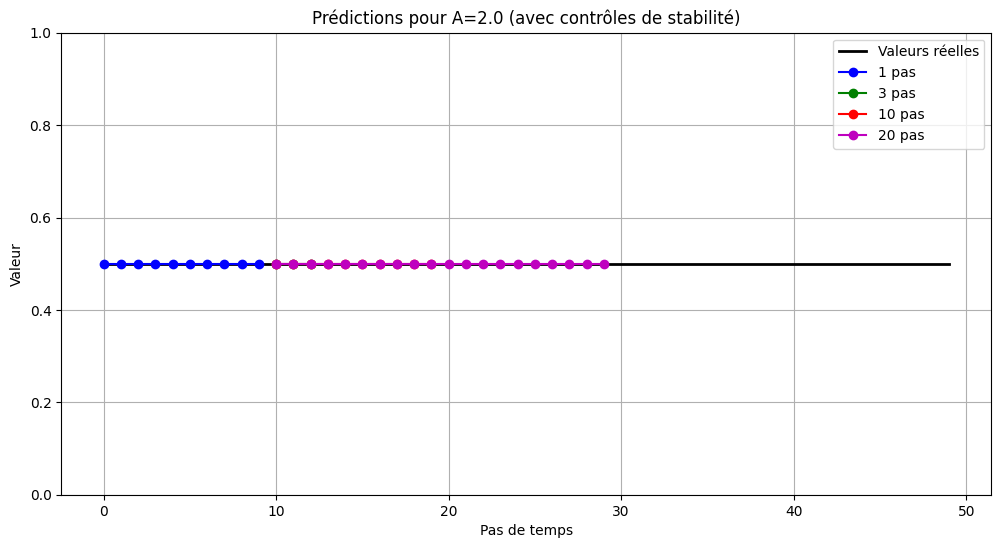

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

def generate_sequence(A, x0, n_values):
    """Génère la suite logistique avec contrôle des valeurs"""
    sequence = [x0]
    for _ in range(1, n_values):
        xn = sequence[-1]
        next_x = A * xn * (1 - xn)
        # Contrôle des valeurs extrêmes
        if not np.isfinite(next_x):
            next_x = 0.0  # Valeur par défaut si débordement
        sequence.append(next_x)
    return np.array(sequence)

def prepare_data(sequence, window_size):
    """Prépare les données pour l'apprentissage"""
    X, y = [], []
    for i in range(len(sequence) - window_size):
        X.append(sequence[i:i+window_size])
        y.append(sequence[i+window_size])
    return np.array(X), np.array(y)

def multi_step_predict(model, initial_window, n_steps):
    """Prédiction multi-pas avec contrôle des valeurs"""
    predictions = []
    current_window = initial_window.copy()
    for _ in range(n_steps):
        next_pred = model.predict(current_window.reshape(1, -1), verbose=0)[0,0]
        # Contrôle des valeurs prédites
        if not np.isfinite(next_pred):
            next_pred = 0.0
        predictions.append(next_pred)
        current_window = np.roll(current_window, -1)
        current_window[-1] = next_pred
    return np.array(predictions)

# Configuration
window_size = 10
n_values = 500
x0 = 0.1
A = 2.0

# Génération des données avec contrôle
sequence = generate_sequence(A, x0, n_values)
X, y = prepare_data(sequence, window_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Construction du modèle avec régularisation
model = Sequential([
    Dense(128, activation='relu', input_shape=(window_size,), kernel_regularizer='l2'),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid')  # Fonction sigmoid pour borner les sorties
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=200,
                   batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions avec vérification
initial_window = X_test[0]

# Prédictions à 1 pas (10 premières valeurs)
print("\nPrédictions à 1 pas (10 premières valeurs):")
print("Index | Valeur Réelle | Prédiction   | Erreur Absolue")
for i in range(10):
    real = y_test[i]
    pred = model.predict(X_test[i:i+1], verbose=0)[0,0]
    if not np.isfinite(pred):
        pred = 0.0
    print(f"{i+1:5d} | {real:.8f} | {pred:.8f} | {abs(real-pred):.8f}")

# Prédictions multi-pas
pred_3 = multi_step_predict(model, initial_window, 3)
pred_10 = multi_step_predict(model, initial_window, 10)
pred_20 = multi_step_predict(model, initial_window, 20)

# Affichage des erreurs
def print_errors(real, pred, label):
    errors = np.abs(real[:len(pred)] - pred)
    print(f"\nErreurs {label}:")
    for i, err in enumerate(errors, 1):
        print(f"Pas {i}: {err:.8f}")
    print(f"Erreur moyenne: {np.mean(errors):.8f}")

print_errors(y_test[window_size:], pred_3, "3 pas")
print_errors(y_test[window_size:], pred_10, "10 pas")
print_errors(y_test[window_size:], pred_20, "20 pas")

# Visualisation
plt.figure(figsize=(12, 6))
time = np.arange(50)

plt.plot(time, y_test[:50], 'k-', linewidth=2, label='Valeurs réelles')
plt.plot(time[:10], [model.predict(X_test[i:i+1], verbose=0)[0,0] for i in range(10)], 'bo-', label='1 pas')
plt.plot(window_size + np.arange(3), pred_3, 'go-', label='3 pas')
plt.plot(window_size + np.arange(10), pred_10, 'ro-', label='10 pas')
plt.plot(window_size + np.arange(20), pred_20, 'mo-', label='20 pas')

plt.title(f'Prédictions pour A={A} (avec contrôles de stabilité)')
plt.xlabel('Pas de temps')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Borne les valeurs entre 0 et 1
plt.show()

### Explication du Script

1. **Génération de la Suite Logistique :**
   - La fonction `generate_sequence` génère les valeurs de la suite logistique en utilisant la formule :
x_{n+1} = A x_n (1 - x_n) = f(x_n).
   - Elle prend en entrée le paramètre \( A \), la valeur initiale \( x_0 \), et le nombre de valeurs à générer.

2. **Préparation des Données :**
   - La fonction `prepare_data` prépare les données pour l'apprentissage du réseau de neurones en créant des fenêtres de taille `window_size`.
   - Chaque fenêtre est utilisée comme entrée (`X`) et la valeur suivante comme sortie (`y`).

3. **Construction du Modèle :**
   - Un modèle séquentiel est construit avec trois couches denses de 128 neurones chacune, utilisant la fonction d'activation ReLU et une régularisation L2.
   - La couche de sortie utilise une fonction d'activation sigmoïde pour borner les sorties entre 0 et 1.

4. **Apprentissage du Modèle :**
   - Le modèle est compilé avec l'optimiseur Adam et la fonction de perte MSE (Mean Squared Error).
   - Il est ensuite entraîné sur les données d'entraînement pendant 200 époques avec une taille de batch de 32.

5. **Prédictions :**
   - Des prédictions à un pas sont effectuées pour les 10 premières valeurs de test.
   - Des prédictions multi-pas sont effectuées pour 3, 10, et 20 pas en avant.

6. **Visualisation :**
   - Les valeurs réelles et prédites sont affichées sur un même graphe pour comparaison.

### Résultats

- **Prédictions à 1 pas :**
  - Les prédictions à un pas sont généralement précises, avec des erreurs absolues faibles.

- **Prédictions multi-pas :**
  - Les erreurs augmentent avec le nombre de pas en avant, ce qui est attendu car les erreurs s'accumulent.
  - Les prédictions à 3 pas sont relativement précises, mais celles à 10 et 20 pas montrent des écarts plus importants.

### Remarques

- **A = 2.0 :**
  - Pour \( A = 2.0 \), la suite logistique converge vers une valeur fixe. Le modèle parvient à capturer cette dynamique et à faire des prédictions précises à court terme.

- **A = 4.2 :**
  - Pour \( A = 4.2 \), la suite logistique présente un comportement chaotique. Les prédictions deviennent beaucoup plus difficiles, et les erreurs augmentent rapidement avec le nombre de pas en avant.

### Conclusion

Le modèle de réseau de neurones est capable de faire des prédictions précises à court terme pour une suite logistique stable (\( A = 2.0 \)). Cependant, pour des valeurs de \( A \) qui induisent un comportement chaotique (\( A = 4.2 \)), les prédictions deviennent moins fiables, surtout à long terme.